In [8]:
import os

import matplotlib

import matplotlib.cm as cm
import matplotlib.animation as animation

import matplotlib.cbook as cbook
import matplotlib.image as image

matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import gdal
import numpy as np
import xarray as xr

import ipywidgets as widgets
import pandas as pd

from IPython.display import clear_output
from IPython.display import display

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [9]:
def get_chunk_size(filename):
    """
    Extract the block size and raster count so that the
    chunks tuple can be formed, a parameter needed to read
    a dataset using xr.open_rasterio() using DASK.
    :param filename: GDAL valid file.
    :return: tuple raster count, x block size, y block size
    """

    # Extract raster count and block size from file
    d = gdal.Open(filename)
    raster_count = d.RasterCount
    # Get internal block size from first band
    b = d.GetRasterBand(1)
    block_size = b.GetBlockSize()
    chunks = (raster_count, block_size[0], block_size[1])

    return chunks

def get_times_from_file_band(fname):
    """
    Extract time info from band metadata
    """
    d = gdal.Open(fname)
    # Get dataset metadata
    dmd = d.GetMetadata()
    bands = d.RasterCount

    # Empty times list
    times = []

    for band in range(bands):
        b = d.GetRasterBand(band+1)
        # Get band metadata
        md = b.GetMetadata()

        # Get fields with date info
        key = 'RANGEBEGINNINGDATE'
        if key in md:
            start_date = md['RANGEBEGINNINGDATE']
        elif key in dmd:
            start_date = dmd['RANGEBEGINNINGDATE']
        else:
            err_msg = f"File {fname} does not have date information"
            raise Exception(err_msg)

        times.append(np.datetime64(start_date))

    return times

In [10]:
# Get monthly ERA5 data
variable = 'total_precipitation'
datadir = '../ERA5/US'

fname = os.path.join(datadir, variable, f'{variable}.tif')
times = get_times_from_file_band(fname)

chunks = get_chunk_size(fname)
#data_array = xr.open_rasterio(fname, chunks=chunks)
data_array = xr.open_rasterio(fname)

data_array = data_array.rename(
    {'x': 'longitude',
     'y': 'latitude',
     'band': 'time'})

data_array['time'] = times

# Get ERA5 t2m stats from daily data
fname = os.path.join(datadir, variable, f'US_REGIONS_mean_{variable}.tif')
_mean = xr.open_rasterio(fname)

fname = os.path.join(datadir, variable, f'US_REGIONS_std_{variable}.tif')
_std = xr.open_rasterio(fname)

# Derive the proxy to the Warm Temperature Index
wti = xr.zeros_like(data_array)

In [11]:
for i, layer in enumerate(data_array):
    wti.data[i] = (data_array.data[i] - _mean.data) / _std.data

In [12]:
def on_dropdown_dates_change(change):
    """
    Handles change event on dropdown_farms widget
    """
    if change['type'] == 'change' and change['name'] == 'value':
        ax.clear()

        i = np.where(times==dropdown_dates.value)[0][0]
        img = wti[i].plot.imshow(ax = ax, vmin=-2.5, vmax=2.5, cmap = 'RdBu', add_colorbar=False)
        ax.set_title(f'Monthly {variable} standard anomalies starting on: {times[i].astype(str)}')
        ax.set_aspect('equal')

        plt.show()
        
def on_click(event):
    """
    Event handler
    """
    # Event does not apply for time series plot
    # Check if the click was in a
    if event.inaxes in [bx]:
        return
    
    bx.clear()
    
    # Delete last reference point
    if len(ax.lines) > 0:
        del ax.lines[0]

    # Draw a point as a reference
    ax.plot(event.xdata, event.ydata
            ,marker='o', color='red', markersize=7, alpha=0.7)
    
    _tmp_mean = _mean.sel(x=event.xdata,
                             y=event.ydata,
                             method='nearest')
    
    _data = data_array.sel(longitude=event.xdata,
                           latitude=event.ydata,
                           method='nearest')
    
    _data.plot(ax=bx, label=f'Monthly ERA5 {variable}', color='Grey')
    
    # Mean
    bx.hlines(_tmp_mean.data[0], data_array.time.data[0], data_array.time.data[-1],
              colors='k', linestyles='-', lw=1.5, label='Mean')   
    
    # 90% and 10% percentile
    _quantile = _data.quantile([0.1,0.9]).data
    bx.hlines(_quantile, data_array.time.data[0], data_array.time.data[-1],
              colors='k', linestyles='--', lw=1.0, label='90% and 10% percentiles')
    
    bx.legend(loc='best', fontsize='small',
                  fancybox=True, framealpha=0.5)
    
    bx.fill_between(data_array.time.data, _quantile[1], _data,
                    where=_data >= _quantile[1],
                    facecolor='blue', interpolate=True, alpha=0.5)
    
    bx.fill_between(data_array.time.data, _quantile[0], _data,
                    where=_data <= _quantile[0],
                    facecolor='red', interpolate=True, alpha=0.5)

    title = bx.get_title()
    bx.set_title(title, fontdict={'horizontalalignment': 'center'})
    
    bx.grid()


In [13]:
# Plot objects
fig, (ax, bx) = plt.subplots(2, 1)
fig.set_size_inches(10, 8)

# Connect the canvas with the event
cid = fig.canvas.mpl_connect('button_press_event', on_click)

#img = ax.imshow(wti[0], cmap = 'RdBu_r', vmin=-2.5, vmax=2.5)
img = wti[0].plot.imshow(ax = ax, cmap = 'RdBu', vmin=-2.5, vmax=2.5, add_colorbar=False)
ax.set_title(f'Monthly {variable} standard anomalies starting on: {times[0].astype(str)}')
ax.set_aspect('equal')
cb = fig.colorbar(img, ax=ax)

bx.grid()

plt.tight_layout()

## Assimila -- Climate Risk Disclosure demo
### ERA 5 total precipitation analysis

This is a demo of how the use [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) data to find extreme events, defined as dates where the observations are above the 90th or below the 10th percentile, these areas will be shown as shaded areas.

- The demo shows the ERA5 total precipitation monthly average for the US from 1979 to 2019.
- The upper panel depicts the standarised anomalies as the number of standard deviations that the observations depart from the climatology.
- The lower panel shows total precipitation the time series

#### How to use it.

- You might want to maximize this window for better visualisation purposes. There is a little toolbar ar the bottom of the plot that will be used to select the kind of interaction you want to use to explore the data.
- Click on the ```Zoom``` icon, then click on a particular area on the map to start extracting temporal profiles of the total precipitation. Using the ```Zoom``` functionality you can zoom in into a particular area of the map or the time series as well by clicking and then dragging the cursor to draw a rectangle.
- Click on the ```Date``` dropdown box to select a particulat month
- Clicking on ```Home``` restores the default settings on the plot.

Dropdown(description='Date:', options=(numpy.datetime64('1979-01-01'), numpy.datetime64('1979-02-01'), numpy.d…

<IPython.core.display.Javascript object>


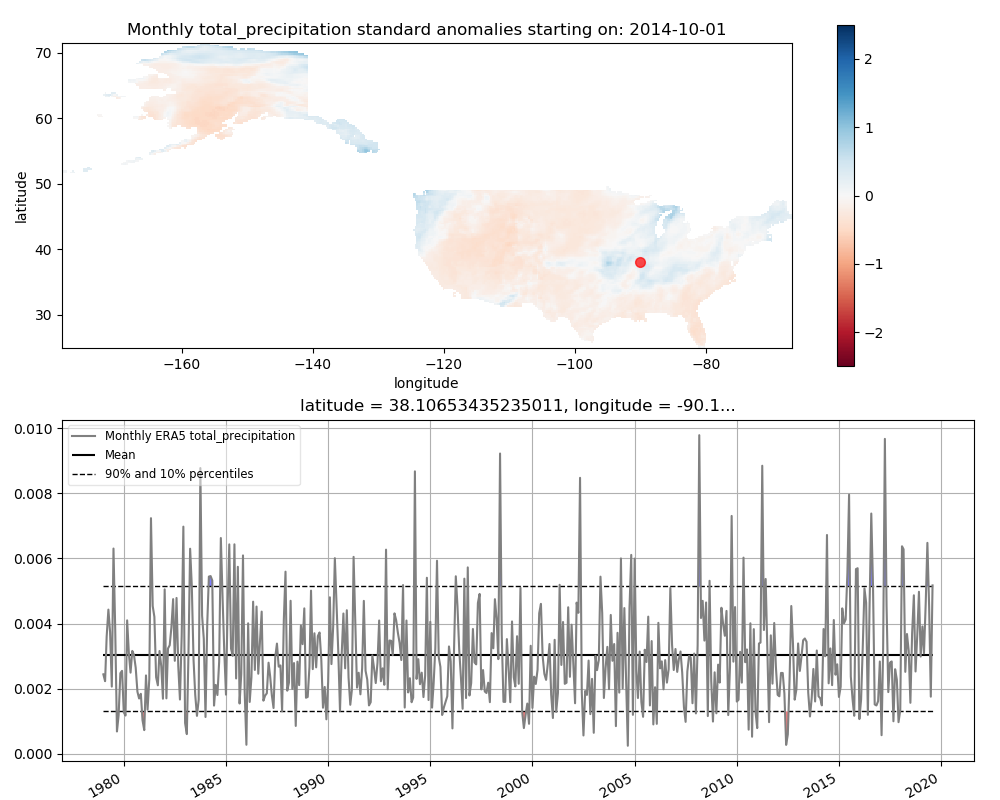

In [14]:
# Dropdown widget with all farms
dropdown_dates = widgets.Dropdown(
    options=times,
    value=times[0],
    description='Date:',
    disabled=False,
)

dropdown_dates.observe(on_dropdown_dates_change)

display(dropdown_dates)
plt.show()